# Transport Solver

In [1]:
using Revise
using FUSE
using Plots;
FUSE.logging(Logging.Info);

[ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]


### Let's initialize the case with the DIII-D standard Hmode case

This is a standard DIII-D shot with some 5MW of NBI and some Hmode initialized profiles (not from experiment)

In [2]:
dd, ini, act = FUSE.init(:D3D, do_plot=false);

### Take a look at the parameters of the actors associated with the transport solver
1. ActorTransportSolver
2. ActorCoreTransport
3. ActorTGLF
4. ActorNeoclassical

In [4]:
#display(act.ActorTransportSolver)
display(act.ActorCoreTransport)
display(act.ActorTGLF)
display(act.ActorNeoclassical)

ActorCoreTransport{Float64}
└─ model ➡ :Tauenn


ActorTGLF{Float64}
├─ electromagnetic ➡ true
├─ nn ➡ true
├─ rho_transport ➡ 0.2:0.1:0.8
├─ sat_rule ➡ :sat1
└─ warn_nn_train_bounds ➡ false


ActorNeoclassical{Float64}
├─ neoclassical_model ➡ :changhinton
└─ rho_transport ➡ 0.2:0.1:0.8


#### We can the actors for the transport fluxes individually

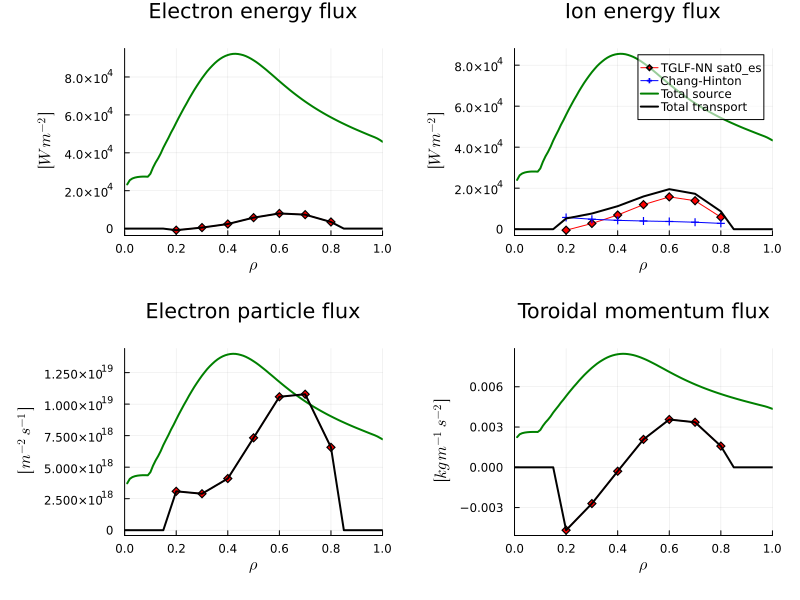

In [5]:
# We are running with the fast tglfnn model
act.ActorTGLF.sat_rule = :sat0
act.ActorTGLF.electromagnetic = false
act.ActorTGLF.nn = true
FUSE.ActorTGLF(dd,act)
FUSE.ActorNeoclassical(dd,act);
plot(dd.core_transport)

#### act.ActorTransportSolver defines what is evolved. In this case:
   -  Electron Temperature Te
   -  Ion temperature Ti
   -  Electron density ne

We are keeping the rotation fixed and use Deuterium for quasi neutrality and let Carbon match the ne_scale lengths

#### Setting up the actor parameters in act is next

In [6]:
# Resetting dd, ini, act so that we don't have to scroll up every time
dd, ini, act = FUSE.init(:D3D, do_plot=false);
#dd, ini, act = FUSE.init(:ITER, init_from=:ods; do_plot=false)

act.ActorTGLF.warn_nn_train_bounds=true
# We are running with the fast tglfnn model
act.ActorTGLF.nn = true
act.ActorTGLF.sat_rule = :sat0
act.ActorTGLF.electromagnetic = false

act.ActorTransportSolver.rho_transport = 0.3:0.1:0.8
act.ActorTransportSolver.max_iterations = 100
act.ActorTransportSolver.optimizer_algorithm = :anderson # or :jacobian_based
act.ActorTransportSolver.step_size = 0.2
act.ActorTransportSolver.verbose = true
act.ActorTransportSolver.evolve_rotation = :fixed

# show pre evolution
display(act.ActorTransportSolver)
display(plot(dd.core_profiles, label=" before"))

#FUSE.ActorPedestal(dd,act)
actor_transport = FUSE.ActorTransportSolver(dd, act)

# show after
display(plot!(dd.core_profiles, label=" after"))

# plot the flux_matching 
display(plot(dd.core_transport))

LoadError: act.ActorTransportSolver does not exist

### For the channels that we evolved the flux_matching looks spot on!

In [ ]:
# let's see if our end result satisfies quasi neutral
IMAS.is_quasi_neutral(dd)

#### How does TGLF compare to TGLF_nn in this case?

In [ ]:
act.ActorTGLF.nn = false

# Dialing the iterations a bit down since tglf_sat0 is much slower than it's neural net counterpart
act.ActorTransportSolver.max_iterations = 30

display(plot(dd.core_profiles, label="  tglfnn"))
FUSE.ActorTransportSolver(dd, act)

display(plot!(dd.core_profiles, label="  tglf"))
display(plot(dd.core_transport))

#### As you can see TGLF sat0 converges well except for a point @ rho = 0.5
#### However, as you can see this doesn't affect the results very much!